In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import jaxley as jx
from time import perf_counter
import numpy as np

# This does
- up to 10x faster import (not verified properly)
- refactor / more modular and simplified graph pipeline
- Adds NEURON backend for SWC reader

# Questions
- how to determine branch direction (and how loc works)? Along edge direction or with ascending comp / node index?
- How to enumerate compartments? Should branchpoint comps get a comp_index?
- Use DiGraph vs Graph? -> Use DiGraph, since synapses need direction?
- do we need solve_graph or traversal in reader?

# TODOS
-[ ] add NEURON backends (open issue to refactor tests using this backend)
    -[ ] write tests and get tests to pass for backend
-[x] pass import / export cycle tests
-[x] pass `test_swc.py`
-[ ] Remove old and dangling code / refactor

# Follow Up questions / todos
- Keep branchpoints and tip nodes in `nodes` and in graph; introduce `compartments` attribute that only shows compartment nodes? Nodes shows all nodes `cell.nodes.loc[is_comp]`
- better ground-truthing vs NEURON (using graph imports from NEURON)
- simpler indexing "global_branch_index" -> "branch"
- refactor / rewrite set_ncomp (can just rebuild using comp_graph), store_compgraph?
- replace old `compute_xyz` with new version
- with the new graph functionality, this should be much easier to do

## Other Ideas:
### Reformat dataframes
- rename `global_X_index` to `X_index`
- use tuples of nodes to index edges
- treat synapses like groups and channels, i.e. boolean indices

In [ ]:
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new

import networkx as nx
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import jax
import pandas as pd

from warnings import warn

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Circle


In [183]:
def graph_vis(graph, dims=(0, 1), ax=None, show_radii=False, jitter=0.0, scale_radii=1.0, radii_kwargs={}, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    add_jitter = lambda x: x + np.random.uniform(-jitter, jitter, size=len(x))
    pos = {
        k: add_jitter(np.array([data["xyz"[d]] for d in dims]))
        for k, data in graph.nodes(data=True)
    }

    nx.draw(graph, pos=pos, ax=ax, **kwargs)

    if show_radii:
        patch_kwargs = dict(edgecolor="C3", facecolor="none", linewidth=1.0, zorder=3)
        patch_kwargs.update(radii_kwargs)

        for k, data in graph.nodes(data=True):
            r = data.get("radius", data.get("r", None))
            R = float(r) * float(scale_radii)
            ax.add_patch(Circle(pos[k], R, **patch_kwargs))

    return ax

def neuron_list_branches(swc_graph: nx.DiGraph) -> list[list[int]]:
    """Creates a list of branches / sections from a NEURON SWC graph.

    This returns the compartment indices (same as the node indices in the compartment graph)
    for each branch / section in the NEURON SWC graph.

    Args:
        swc_graph: A NEURON SWC graph (created with `neuron_swc_graph()`).

    Returns:
        A list of lists, where each sublist contains the compartment indices for a branch
        and the index of each list corresponds to the branch index.
    """
    secs = nx.get_node_attributes(swc_graph, "sec_name")
    branches = {k: [] for k in secs.values()}
    for k, v in secs.items():
        branches[v].append(k)
    return list(branches.values())

def old_list_branches(swc_graph, ignore_swc_tracing_interruptions=True):
    traced_branches = []
    mod_graph, branches, *_ = graph_io_old._trace_branches(swc_graph, ignore_swc_tracing_interruptions=ignore_swc_tracing_interruptions)
    for branch in branches:
        traced_branches.append(np.unique(branch[:,:-1].flatten().astype(int)).tolist())
    return traced_branches, mod_graph

def match_branches(input_swc_graph: nx.DiGraph, target_swc_graph: nx.DiGraph, input_branches: list[list[int]], target_branches: list[list[int]], match_on: str = "xyz", tol: float = 1e-3) -> list[list[int]]:
    """Matches the branches in the input graph to the branches in the target graph.

    The returned branch list is ordered in the same way as the target branch list. In
    addition, the branches are made to have the same direction as the target branches.

    Args:
        input_swc_graph: A graph representation of a SWC file.
        target_swc_graph: A graph representation of a SWC file.
        input_branches: A list of lists, where each sublist contains the compartment indices
            for a branch in the input graph.
        target_branches: A list of lists, where each sublist contains the compartment indices
            for a branch in the target graph.
        match_on: The attributes to match on, i.e. ["x", "y", "z"] to match on the x, y, 
            and z coordinates.
        tol: The tolerance for the matching, i.e. 1e-3 considers two nodes to be the same 
            if the distance between them is less than 1e-3.

    Returns:
        The input branches reordered to match the target branches.
    """
    assert len(input_branches) == len(target_branches), "Number of branches is not the same"
    
    input_nodes = np.array(list(input_swc_graph.nodes()))
    target_nodes = np.array(list(target_swc_graph.nodes()))

    input_xyz = np.array([unpack_dict(d, match_on) for n, d in input_swc_graph.nodes(data=True)])
    target_xyz = np.array([unpack_dict(d, match_on) for n, d in target_swc_graph.nodes(data=True)])

    # compute pairwise distances between the nodes in the input and target graph
    dists = cdist(input_xyz, target_xyz)
    
    # if there is multiple targets for one input, keep the closest target
    input_idx = np.arange(dists.shape[0])
    target_idx = np.argmin(dists, axis=1)
    min_dists = np.min(dists, axis=1)
    if tol:
        keep = min_dists < tol
        input_idx = input_idx[keep]
        target_idx = target_idx[keep]

    # align input and target nodes
    input_nodes = input_nodes[input_idx]
    target_nodes = target_nodes[target_idx]
    input2target = {n_i: n_t for n_i, n_t in zip(input_nodes, target_nodes)}


    # branch index of the target nodes
    branch_of_target_node = {n: np.where([n in b for b in target_branches])[0] for n in sum(target_branches, [])}
    # corresponding branch index of the input nodes in the target graph
    branch_targets = [np.hstack([branch_of_target_node[input2target[n]] for n in b]) for b in input_branches]
    # each node in the input graph, i.e. [[1,2,3,4,5], [...]] has corresponding 
    # branch index in the target graph, i.e. [[0,1,1,1,1,2], [...]] The 
    # corresponding branch index will be assigned based on the most common target branch
    # index for the input nodes, i.e. branch 0 in the input will be assigned to branch 1
    # in the target graph.

    # reorder the input branches to match the target branches
    new_order = np.argsort([max(set(b), key=b.tolist().count) for i, b in enumerate(branch_targets)])
    input_branches = [input_branches[i] for i in new_order]

    # reverse node order of the input branches if they are not in the same direction as 
    # the target branches
    for i, b_in in enumerate(input_branches):
        b_in_start_xyz = unpack_dict(input_swc_graph.nodes[b_in[0]], "xyz")
        b_in_end_xyz = unpack_dict(input_swc_graph.nodes[b_in[-1]], "xyz")
        b_target_start_xyz = unpack_dict(target_swc_graph.nodes[input2target[b_in[0]]], "xyz")
        dist_start2start = np.linalg.norm(b_in_start_xyz - b_target_start_xyz)
        dist_end2start = np.linalg.norm(b_in_end_xyz - b_target_start_xyz)
        if dist_start2start > dist_end2start:
            input_branches[i] = input_branches[i][::-1]

    return input_branches

def match_nodes(input_graph: nx.DiGraph, target_graph: nx.DiGraph, match_on: str = "xyzr", tol: float = 1e-3, assert_unique: bool = True, assert_all: bool = True) -> nx.DiGraph:
    """Matches the nodes in the input graph to the nodes in the target graph.

    The returned graph is relabeled such that the corresponding nodes in the input and target
    graph have the same node indices.

    Args:
        input_graph: A graph (either a SWC graph or a compartment graph).
        target_graph: A graph (either a SWC graph or a compartment graph).
        match_on: The attributes to match on, i.e. ["x", "y", "z"] to match on the x, y, 
            and z coordinates.
        tol: The tolerance for the matching, i.e. 1e-3 considers two nodes to be the same 
            if the distance between them is less than 1e-3.
        assert_unique: Whether to assert that the nodes are matched uniquely. If False,
            the nodes not all nodes will have a unique match.

    Returns:
        The input graph relabeled to have the same node indices as the target graph.
    """
    input_nodes = np.array(list(input_graph.nodes()))
    target_nodes = np.array(list(target_graph.nodes()))

    input_node_xyz = np.array([unpack_dict(d, match_on) for n, d in input_graph.nodes(data=True)])
    target_node_xyz = np.array([unpack_dict(d, match_on) for n, d in target_graph.nodes(data=True)])

    # compute pairwise distances between the nodes in the input and target graph
    dists = cdist(input_node_xyz, target_node_xyz)
    # is_close = np.isclose(dists, 0, atol=tol)
    # input_idx, target_idx = np.where(is_close)
    
    # if there is multiple targets for one input, keep the closest target
    input_idx = np.arange(dists.shape[0])
    target_idx = np.argmin(dists, axis=1)
    min_dists = np.min(dists, axis=1)
    keep = min_dists < tol
    if tol:
        input_idx = input_idx[keep]
        target_idx = target_idx[keep]

    if assert_all:
        assert np.all(keep), f"Unable to match {input_nodes[~keep]}."

    # find nodes that are not matched uniquely
    if assert_unique:
        input_unique, input_counts = np.unique(input_idx, return_counts=True)
        target_unique, target_counts = np.unique(target_idx, return_counts=True)
        assert np.all(input_counts == 1), f"Some input nodes were not matched uniquely: {input_nodes[input_counts != 1]}"
        assert np.all(target_counts == 1), f"Some target nodes were not matched uniquely: {target_nodes[target_counts != 1]}"

    old_labels = input_nodes[input_idx].tolist()
    new_labels = target_nodes[target_idx].tolist()
    
    # prevent overlap of new and old labels
    affected_labels = set(old_labels + new_labels) & set(input_nodes)
    tmp_labels = graph_io_new.propose_new_inds(set(input_nodes), len(affected_labels))
    affected2tmp = dict(zip(affected_labels, tmp_labels))
    input_graph = nx.relabel_nodes(input_graph, affected2tmp)

    # relabel nodes on input graph
    tmp2new = dict(zip([affected2tmp[n] for n in old_labels], new_labels))
    input_graph = nx.relabel_nodes(input_graph, tmp2new)

    return input_graph

def match_edges(input_graph, target_graph, raise_if_not_found=True):
    input_edges = input_graph.edges()
    target_edges = target_graph.edges()
    for (i,j) in target_edges:
        if (i,j) in input_edges:
            continue
        elif (j,i) in input_edges:
            edge_attrs = input_graph.edges[(j,i)]
            input_graph.remove_edge(j,i)
            input_graph.add_edge(i,j, **edge_attrs)
        elif raise_if_not_found:
            raise ValueError(f"Could not find edge between {i,j} in input graph")            
    return input_graph

def compare_node_attrs(input_graph: nx.DiGraph, target_graph: nx.DiGraph, key: str, func: Callable = jnp.isclose, reduce: Callable = all, subset: Optional[list[int]] = None):
    """Compares the node attributes of the input and target graph.

    Graphs are compared by their node indices / labels. This means corresponding nodes in the
    input and target graph should have the same node indices. To do this you can use 
    `match_nodes()` to relabel the input graph to have the same node indices as the target 
    graph, before running this function.

    Args:
        input_graph: A graph.
        target_graph: A graph.
        key: The attribute to compare.
        func: The function to use to compare the attributes.
        reduce: The function to use to reduce the comparison results.
        subset: A list of node indices to compare.

    Returns:
        The comparison results.
    """
    if subset is not None:
        input_graph = input_graph.subgraph(subset)
        target_graph = target_graph.subgraph(subset)

    input_attrs = nx.get_node_attributes(input_graph, key)
    target_attrs = nx.get_node_attributes(target_graph, key)
    is_equal = jax.tree_util.tree_map(lambda x, y: func(x, y), input_attrs, target_attrs)
    if reduce is not None:
        return reduce(jnp.array(jax.tree.flatten(is_equal)[0]))
    return is_equal
    
def print_or_assert(cond, msg, print_only=True):
    if print_only:
        if not cond:
            print(msg)
        else:
            return
    else:
        assert cond, msg

def compute_branch_features(graph, branches):
    def path_lengths(xyz):
        d = np.diff(xyz, axis=0)
        seg = np.linalg.norm(d, axis=1)
        s = np.concatenate([[0.0], np.cumsum(seg)])
        return s

    def length_weighted_mean(values, s):
        L = s[-1]
        return np.trapezoid(values, s) / L if L > 0 else 0.0

    xyzrs = [np.array([unpack_dict(graph.nodes[n], "xyzr") for n in b]) for b in branches]
    ls = [path_lengths(xyzr_i[:, :3]) for xyzr_i in xyzrs]
    branch_lens = [np.sum(l) for l in ls]
    avg_x = [length_weighted_mean(xyzr_i[:, 0], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_y = [length_weighted_mean(xyzr_i[:, 1], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_z = [length_weighted_mean(xyzr_i[:, 2], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_radius = [length_weighted_mean(xyzr_i[:, 3], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]

    fts = [branch_lens, avg_x, avg_y, avg_z, avg_radius]
    return np.array([np.hstack(f) for f in zip(*fts)])

In [ ]:
# FAILED tests/jaxley_identical/test_swc.py::test_swc_cell[morph_ca1_n120_single_point_soma.swc-jaxley.dhs.cpu] - AssertionError: Error is 45.43523183465675 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_cell[morph_ca1_n120.swc-jaxley.dhs.cpu] - AssertionError: Error is 5.481764604184292 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jaxley.dhs.cpu-morph_ca1_n120] - AssertionError: Error is 5.481764604184292 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jax.sparse-morph_ca1_n120] - AssertionError: Error is 5.4817646041872585 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jaxley.dhs.cpu-morph_ca1_n120_250] - AssertionError: Error is 6.045891080393293 > 1e-08
# FAILED tests/jaxley_identical/test_swc.py::test_swc_net[jaxley.dhs.gpu-morph_ca1_n120_250] - AssertionError: Error is 6.045891080393783 > 1e-08

In [275]:
# fname = "tests/swc_files/morph_ca1_n120_single_point_soma.swc"
# # swc_df = graph_io_new.load_swc(fname)
# # new_swc_graph = graph_io_new.swc_to_nx(swc_df)


# neuron_swc_graph = swc_to_nx_with_neuron(fname)
# neuron_comp_graph_from_swc = graph_io_new.build_compartment_graph(
#     neuron_swc_graph,
#     ncomp=1,
#     max_len=2000.0,
#     ignore_swc_tracing_interruptions=False,
# )
# neuron_comp_graph = build_compartment_graph()

# neuron_cell_from_swc = graph_io_new.from_graph(neuron_comp_graph_from_swc)
# neuron_cell_direct = graph_io_new.from_graph(neuron_comp_graph)

# old_cell = jx.read_swc(fname, ncomp=1, ignore_swc_tracing_interruptions=False, max_branch_len=2000.0)

In [64]:
# # TODO: ensure exported branch graph is same as imported graph and same as module graph
# newG = nx.Graph()
# newG.add_edges_from(new_cell.branch_edges.values)
# newG.add_nodes_from(new_cell.nodes.set_index("global_branch_index")[["x", "y", "z"]].iterrows())

# branch_graph = comp_to_branch_graph(graph_io_new._extract_branchpoints(new_comp_graph))

# re_branch_graph = comp_to_branch_graph(graph_io_new.to_graph(new_cell))

# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# graph_vis(newG, ax=ax, node_size=0, node_color="b", arrows=False, edge_color="b", width=4.0)
# graph_vis(branch_graph, ax=ax, node_size=0, node_color="r", arrows=False, edge_color="r", width=2.5)
# graph_vis(re_branch_graph, ax=ax, node_size=0, node_color="g", arrows=False, edge_color="g", width=1.0)

<Axes: >

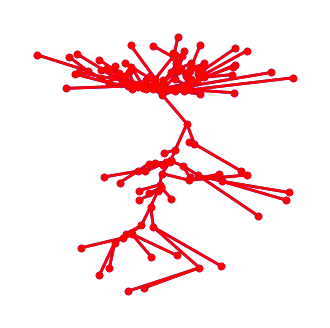

In [271]:
neuron_from_swc_G = nx.Graph()
neuron_from_swc_G.add_edges_from(neuron_cell_from_swc.branch_edges.values)
neuron_from_swc_G.add_nodes_from(neuron_cell_from_swc.nodes.set_index("global_branch_index")[["x", "y", "z"]].iterrows())

neuron_direct_G = nx.Graph()
neuron_direct_G.add_edges_from(neuron_cell_direct.branch_edges.values)
neuron_direct_G.add_nodes_from(neuron_cell_direct.nodes.set_index("global_branch_index")[["x", "y", "z"]].iterrows())

oldG = nx.Graph()
oldG.add_edges_from(old_cell.branch_edges.values)
oldG.add_nodes_from(old_cell.nodes.set_index("global_branch_index")[["x", "y", "z"]].iterrows())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# graph_vis(neuron_from_swc_G, ax=ax, node_size=20, node_color="b", arrows=False, edge_color="b", width=2.0)
graph_vis(neuron_direct_G, ax=ax, node_size=20, node_color="b", arrows=False, edge_color="b", width=2.0)
graph_vis(oldG, ax=ax, node_size=20, node_color="r", arrows=False, edge_color="r", width=2.0)

# plt.xlim(-30, 50)
# plt.ylim(-250, -40)

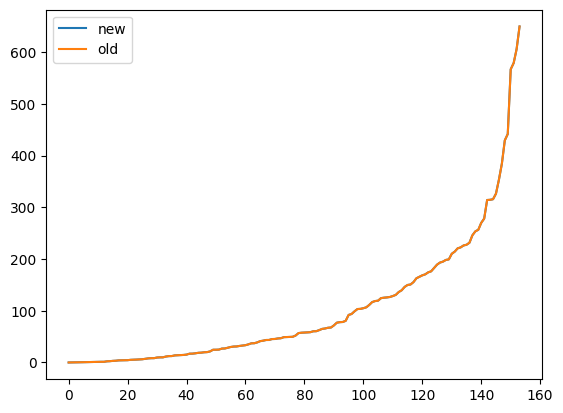

In [360]:
col = "resistive_load_in"
new_cell_nodes = new_cell.nodes.sort_values(col)
old_cell_nodes = old_cell.nodes.sort_values(col)

notclose = ~np.isclose(new_cell_nodes[col].values, old_cell_nodes[col].values)

plt.plot(new_cell_nodes[col].values, label="new")
plt.plot(old_cell_nodes[col].values, label="old")
plt.legend()

(-15.0, 5.0)

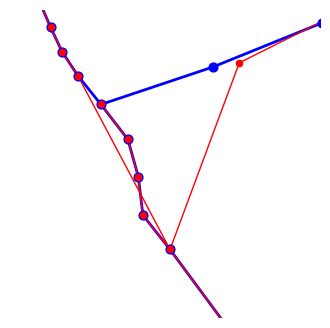

In [2101]:
#### NEURON SWC READER ADDS EDGES THAT ARE NOT IN THE SWC FILE !?!?!?!?!?####

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"
neuron_swc = swc_to_nx_with_neuron(fname, merge_branchpoints=True)

# neuron_swc.remove_edge(8, 601)
# neuron_swc.add_edge(601, 0)
# neuron_swc.remove_edge(8, 0)

# jaxley_swc = graph_io_new.swc_to_nx(fname)

# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# graph_vis(jaxley_swc, ax=ax, node_size=20, node_color="b", arrows=False, edge_color="b", width=2.0)
# graph_vis(neuron_swc, ax=ax, node_size=40, node_color="r", arrows=False, edge_color="r", width=1.0, with_labels=True)
# soma_nodes = [n for n, d in neuron_swc.nodes(data=True) if d["id"] == 1]
# # graph_vis(neuron_swc.subgraph(soma_nodes), ax=ax, node_size=40, node_color="r", arrows=False, edge_color="r", width=1.0)
# # graph_vis(neuron_swc.subgraph(soma_nodes), ax=ax, node_size=40, node_color="r", arrows=False, edge_color="r", width=2, show_radii=True)

# ax.set_xlim(-1, 5)
# ax.set_ylim(-13, 2)

ncomp = 5
solve_graph_neuron = build_solve_graph_with_neuron(fname, ncomp=ncomp, drop_neuron_specific_attrs=True)

comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=ncomp, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)
solve_graph_jaxley = graph_io_new._replace_branchpoints_with_edges(comp_graph_jaxley)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
graph_vis(solve_graph_jaxley, ax=ax, node_size=40, node_color="b", arrows=False, edge_color="b", width=2.0)
graph_vis(solve_graph_neuron, ax=ax, node_size=20, node_color="r", arrows=False, edge_color="r", width=1.0)

ax.set_xlim(-3, 9)
ax.set_ylim(-15, 5)

In [1433]:
##### ALL MORPH NODE ATTRIBUTES MATCH BETWEEN NEURON AND JAXLEY GRAPHS #####

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

ncomps = 1
neuron_swc_reader(fname, ncomps)
neuron_swc = neuron_swc_graph()
branches_neuron = neuron_list_branches(neuron_swc)
neuron_swc = contract_similar_nodes(neuron_swc)
solve_graph_neuron = neuron_solve_graph(ncomp=ncomps)

jaxley_swc = graph_io_new.swc_to_nx(fname)
branches_jaxley = graph_io_new.list_branches(jaxley_swc, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new.build_compartment_graph(jaxley_swc, ncomp=ncomps, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)
solve_graph_jaxley = graph_io_new._replace_branchpoints_with_edges(comp_graph_jaxley)

# match swc against neuron
matched_jaxley_swc = match_nodes(jaxley_swc.copy(), neuron_swc)
for key in ["r", "l", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(neuron_swc, matched_jaxley_swc, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all), f"|{key}-{key}'| > {1e-5} for some nodes")

# # match branches
# assert len(branches_jaxley) == len(branches_neuron), "Number of branches is not the same"
# branches_jaxley = match_branches(jaxley_swc, neuron_swc, branches_jaxley, branches_neuron)

# match comp graph against neuron
comp_graph_jaxley = match_nodes(comp_graph_jaxley, solve_graph_neuron, match_on="xyz", tol=1e-3, assert_unique=False)
shared_nodes = set(comp_graph_jaxley.nodes()) & set(solve_graph_neuron.nodes())
for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(comp_graph_jaxley, solve_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all, subset=shared_nodes), f"|{key}-{key}'| > {1e-5} for some nodes")

# match solve graph against neuron
solve_graph_jaxley = match_nodes(solve_graph_jaxley, solve_graph_neuron, match_on="xyz", tol=1e-3)
for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(solve_graph_jaxley, solve_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all, subset=shared_nodes), f"|{key}-{key}'| > {1e-5} for some nodes")

# match modules

(-13.0, 2.0)

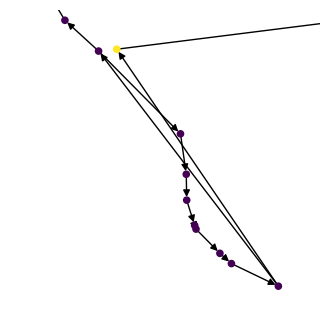

In [2102]:
neuron_swc_reader(fname)
swc_graph_neuron = neuron_swc_graph(merge_branchpoints=True)
# these need to be removed for some reaon!?
# swc_graph_neuron.remove_edge(8, 601)
# swc_graph_neuron.remove_edge(8, 0)
# swc_graph_neuron.add_edge(601, 0)

subg = swc_graph_neuron.subgraph(list(range(13)) + list(range(601, 604)))
node_colors = [subg.nodes[n].get('id', 0) for n in subg.nodes()]
graph_vis(subg, node_size=20, node_color=node_colors)
plt.xlim(-2, 5)
plt.ylim(-13, 2)

In [2173]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

h.secondorder = 0

for sec in h.allsec():
    h.delete_section(sec=sec)

cell = h.Import3d_SWC_read()
cell.input(fname)
i3d = h.Import3d_GUI(cell, False)
i3d.instantiate(None)

for sec in h.allsec():
    sec.nseg = 1
neuron_branch_lens = np.sort([sec.L for sec in h.allsec()])

# pre-processing
swc_graph = graph_io_new.swc_to_nx(fname)
comp_graph = graph_io_new.build_compartment_graph(
    swc_graph, ncomp=1, ignore_swc_tracing_interruptions=False
)

df = pd.Series(nx.get_node_attributes(comp_graph, "l"))
nx_branch_lens = df[df.notna()].sort_values().values


errors = np.abs(neuron_branch_lens - nx_branch_lens)

# plt.plot(neuron_branch_lens)
# plt.plot(nx_branch_lens)
assert sum(errors > 1e-3) == 0

AssertionError: 

In [2106]:
from neuron import h

import jaxley as jx
from jaxley.channels import HH

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

i_delay = 5.0
i_dur = 20.0
i_amp = 1.0
t_max = 30.0
dt = 0.025

stim_loc = 0.51
loc = 0.51

ncomp_per_branch = 3

##################### NEURON ##################
h.secondorder = 0

for sec in h.allsec():
    h.delete_section(sec=sec)

cell = h.Import3d_SWC_read()
cell.input(fname)
i3d = h.Import3d_GUI(cell, False)
i3d.instantiate(None)

for sec in h.allsec():
    sec.nseg = ncomp_per_branch

pathlengths_neuron = np.asarray([sec.L for sec in h.allsec()])

####################### jaxley ##################
# ## bachend = "neuron-swc"
# neuron_swc_reader(fname)
# swc_graph_neuron = neuron_swc_graph(merge_branchpoints=True)
# # these need to be removed for some reaon!?
# swc_graph_neuron.remove_edge(8, 601)
# swc_graph_neuron.remove_edge(8, 0)
# swc_graph_neuron.add_edge(601, 0)
# for n in swc_graph_neuron.nodes():
#     del swc_graph_neuron.nodes[n]["sec_name"]
# comp_graph_neuron = graph_io_new.build_compartment_graph(swc_graph_neuron, ncomp=ncomp_per_branch, max_len=2_000.0)
# cell = graph_io_new.from_graph(comp_graph_neuron)

# ## backend = "neuron-full"
# neuron_swc_reader(fname)
# solve_graph_neuron = neuron_solve_graph(ncomp=ncomp_per_branch)
# cell = graph_io_new._build_module(solve_graph_neuron)

# ## backend = "graph-new"
# jaxley_swc_new = graph_io_new.swc_to_nx(fname)
# comp_graph_new = graph_io_new.build_compartment_graph(jaxley_swc_new, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
# cell = graph_io_new.from_graph(comp_graph_new)

# ## backend = "graph-old"
jaxley_swc_old = graph_io_old.to_swc_graph(fname)
comp_graph_old = graph_io_old.build_compartment_graph(jaxley_swc_old, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
cell = graph_io_old.from_graph(comp_graph_old)

pathlengths = []
for branch in cell.branches:
    pathlengths.append(branch.nodes["length"].sum())
pathlengths_jaxley = np.asarray(pathlengths)

jaxley_inds = [0, 1, 2, 5, 10, 16, 20, 40, 60, 80]
jaxley_inds = [ind for ind in jaxley_inds if ind < len(pathlengths_jaxley)]

neuron_inds = []
for jaxley_ind in jaxley_inds:
    for i, p in enumerate(pathlengths_jaxley):
        if i == jaxley_ind:
            closest_match = np.argmin(np.abs(pathlengths_neuron - p))
            neuron_inds.append(closest_match)

cell.insert(HH())
cell.set("axial_resistivity", 100.0)
cell.set("v", -62.0)
cell.set("HH_m", 0.074901)
cell.set("HH_h", 0.4889)
cell.set("HH_n", 0.3644787)

jaxley_stim = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.soma.branch(0).loc(stim_loc).stimulate(jaxley_stim)
for i in jaxley_inds:
    cell.branch(i).loc(loc).record(verbose=False)

voltages_jaxley = jx.integrate(cell, delta_t=dt, voltage_solver="jaxley.dhs.cpu")

################### NEURON #################
stim = h.IClamp(h.soma[0](stim_loc))
stim.delay = i_delay
stim.dur = i_dur
stim.amp = i_amp

counter = 0
voltage_recs = {}

for r in neuron_inds:
    for i, sec in enumerate(h.allsec()):
        if i == r:
            v = h.Vector()
            v.record(sec(loc)._ref_v)
            voltage_recs[f"v{counter}"] = v
            counter += 1

for sec in h.allsec():
    sec.insert("hh")
    sec.Ra = 100.0

    sec.gnabar_hh = 0.120  # S/cm2
    sec.gkbar_hh = 0.036  # S/cm2
    sec.gl_hh = 0.0003  # S/cm2
    sec.ena = 50  # mV
    sec.ek = -77.0  # mV
    sec.el_hh = -54.3  # mV

h.dt = dt
tstop = t_max
v_init = -62.0

def initialize():
    h.finitialize(v_init)
    h.fcurrent()

def integrate():
    while h.t < tstop:
        h.fadvance()

initialize()
integrate()
voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])
errors = np.mean(np.abs(voltages_jaxley - voltages_neuron), axis=1)

Added 1 external_states. See `.externals` for details.


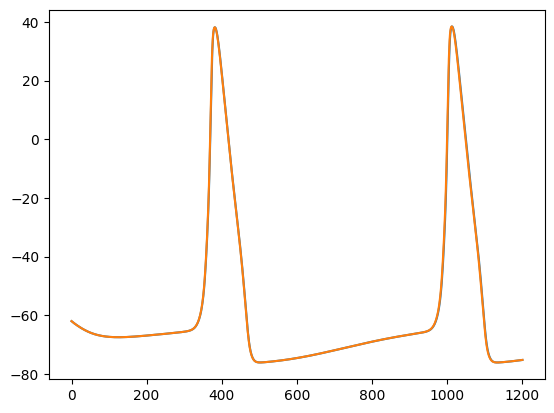

In [2108]:
plt.plot(voltages_neuron[0], label="neuron")
# plt.plot(voltages_jaxley_old[0], label="jaxley old")
plt.plot(voltages_jaxley[0], label="new")

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


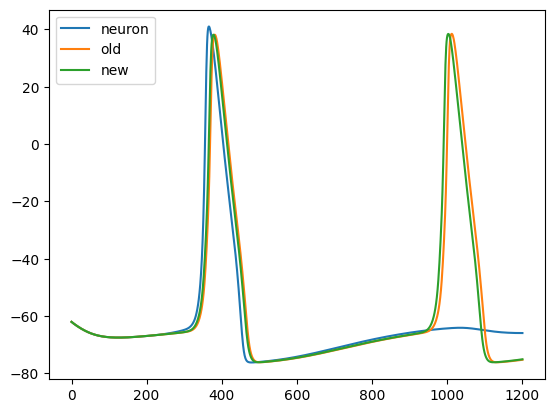

In [276]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

ncomp_per_branch = 3

neuron_swc_reader(fname)
comp_graph_neuron = neuron_comp_graph(ncomp=ncomp_per_branch)
cell_neuron = graph_io_new._build_module(comp_graph_neuron)

swc_graph_new = graph_io_new.swc_to_nx(fname)
comp_graph_new = graph_io_new.build_compartment_graph(swc_graph_new, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
cell_new = graph_io_new.from_graph(comp_graph_new)

cell_old = jx.read_swc(
    fname,
    ncomp=ncomp_per_branch,
    max_branch_len=2_000.0,
    assign_groups=True,
    backend="graph",
    ignore_swc_tracing_interruptions=False,
)

loc = 0.51
rec_inds = [0, 1, 2, 5, 10, 16, 20, 40, 60, 80]
rec_xyz = np.concatenate([cell_old.branch(i).loc(loc).nodes[["x", "y", "z"]].values for i in rec_inds])

stim_loc = 0.51
stim_xyz = cell_old.soma.branch(0).loc(stim_loc).nodes[["x", "y", "z"]].values
stimulus = jx.step_current(i_delay = 5.0, i_dur = 20.0, i_amp = 1.0, delta_t = 0.025, t_max = 30.0)

for cell in [cell_old, cell_neuron, cell_new]:
    cell.insert(HH())
    cell.set("axial_resistivity", 100.0)
    cell.set("v", -62.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)

    xyzs = cell.nodes[["x", "y", "z"]].values
    dists = cdist(xyzs, stim_xyz)
    idx = np.argmin(dists, axis=0)
    cell.select(idx).stimulate(stimulus)

    dists = cdist(xyzs, rec_xyz)
    rec_idxs = np.argmin(dists, axis=0)
    for i in rec_idxs:
        cell.select(i).record(verbose=False)

voltages_neuron = jx.integrate(cell_neuron, delta_t=dt, voltage_solver="jaxley.dhs.cpu")
voltages_old = jx.integrate(cell_old, delta_t=dt, voltage_solver="jaxley.dhs.cpu")
voltages_new = jx.integrate(cell_new, delta_t=dt, voltage_solver="jaxley.dhs.cpu")

plt.plot(voltages_neuron[0], label="neuron")
plt.plot(voltages_old[0], label="old")
plt.plot(voltages_new[0], label="new")
plt.legend()

In [1569]:
fpath = "../jaxley/tests/swc_files"
fname = "morph_ca1_n120_250.swc"

swc_jaxley = graph_io_new.swc_to_nx(os.path.join(fpath, fname))

comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=3, max_len=2000.0, ignore_swc_tracing_interruptions=False)
# cell = graph_io_new.from_graph(comp_graph_jaxley)


In [ ]:
def to_graph(module):
    edges = module.edges.set_index(["pre_index", "post_index"])
    edges.index.names = (None, None)

    G = graph_io_new.pandas_to_nx(module.nodes, edges, pd.Series())

    global_attrs = ["xyzr", "channels", "synapses", "group_names", "branchpoints_and_tips"]
    for attr in global_attrs:
        G.graph[attr] = getattr(module, attr)

    G = graph_io_new._replace_edges_with_branchpoints(G) # TODO: fix this
    return G

def set_ncomp(cell, branch, ncomp):
    branch_xyzr = cell.xyzr[branch]
    node_df = pd.DataFrame(branch_xyzr, columns=["x", "y", "z", "r"])
    node_df["id"] = 0 # dummy id

    # assert no synapses attached to branch
    # assert attrs other than xyzr along branch are the same

    branch_comps = graph_io_new.compartmentalize_branch(node_df, ncomp)
    # TODO: Finish this

In [ ]:
def set_ncomp(view, ncomp):
    from jaxley.io.graph import branch_comps_from_nodes

    new_branch_comps = []
    for branch_idx in view._branches_in_view:
        branch = view.branch(branch_idx)
        node_attrs = pd.DataFrame(branch.xyzr[0], columns=["x", "y", "z", "r"])
        node_attrs["id"] = 0
        new_comps = branch_comps_from_nodes(node_attrs, ncomp)
        comp_cols = ["is_comp","id", "length", "x", "y", "z", "radius", "area", "volume"]
        comp_df = pd.DataFrame(new_comps, columns=comp_cols)
        comp_df = comp_df.loc[comp_df["is_comp"].astype(bool)].drop(columns=["id", "is_comp"])
        
        for name, is_group in branch.nodes[branch.group_names].all().items():
            comp_df.loc[:, name] = is_group

        comp_df["global_cell_index"] = branch.nodes["global_cell_index"].iloc[0]
        comp_df["global_branch_index"] = branch.nodes["global_branch_index"].iloc[0]
        comp_df["v"] = np.mean(branch.nodes["v"])
        comp_df["axial_resistivity"] = np.mean(branch.nodes["axial_resistivity"])
        comp_df["capacitance"] = np.mean(branch.nodes["capacitance"])
            
        comp_df.index = [-1]*len(comp_df.index)

        new_branch_comps.append(comp_df)

    for branch_idx, branch_comps in zip(view._branches_in_view, new_branch_comps):
        branch_nodes = view.nodes[view.nodes["global_branch_index"] == branch_idx].index
        view.base.nodes = pd.concat([view.base.nodes.loc[:branch_nodes[0]], branch_comps, view.base.nodes.loc[branch_nodes[-1]:]], ignore_index=True, join="outer")
    
    view.base.nodes["global_comp_index"] = np.arange(len(view.base.nodes))
    view.base._init_view()
    view.base._update_local_indices()
    

set_ncomp(cell.branch(0), 5)

In [640]:
swc_graph_old = graph_io_old.to_swc_graph(fname)
comp_graph_old = graph_io_old.build_compartment_graph(swc_graph_old, ncomp=1, max_len=1e-10)
test_cell = graph_io_old.from_graph(comp_graph_old)
